In [ ]:
! pip install wave pandas numpy matplotlib librosa tensorflow seaborn tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1220 sha256=f8c155bc012532f92d7c6b8efa6745b3f548adc2c063e652fda75e58a37c723f
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
df_no_diagnosis = pd.read_csv('/content/drive/MyDrive/AIRSA/demographic_info.txt', names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('/content/drive/MyDrive/AIRSA/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [ ]:
root = '/content/drive/MyDrive/AIRSA/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [ ]:
print(filenames)

['160_1b3_Al_mc_AKGC417L', '160_1b3_Lr_mc_AKGC417L', '160_1b3_Pl_mc_AKGC417L', '160_1b3_Ar_mc_AKGC417L', '160_1b3_Pr_mc_AKGC417L', '160_1b4_Ar_mc_AKGC417L', '160_1b4_Lr_mc_AKGC417L', '160_2b4_Pl_mc_AKGC417L', '160_1b4_Pl_mc_AKGC417L', '160_1b4_Pr_mc_AKGC417L', '160_2b3_Lr_mc_AKGC417L', '160_1b4_Tc_mc_AKGC417L', '160_2b4_Pr_mc_AKGC417L', '160_2b4_Ar_mc_AKGC417L', '162_1b2_Ll_mc_AKGC417L', '161_1b1_Al_sc_Meditron', '162_1b2_Al_mc_AKGC417L', '160_2b4_Tc_mc_AKGC417L', '162_1b2_Ar_mc_AKGC417L', '162_1b2_Pl_mc_AKGC417L', '161_1b1_Pl_sc_Meditron', '162_1b2_Lr_mc_AKGC417L', '162_2b2_Tc_mc_AKGC417L', '162_2b2_Al_mc_AKGC417L', '162_1b2_Pr_mc_AKGC417L', '162_2b2_Pl_mc_AKGC417L', '162_1b2_Tc_mc_AKGC417L', '162_2b2_Ar_mc_AKGC417L', '162_2b2_Pr_mc_AKGC417L', '162_2b3_Tc_mc_AKGC417L', '162_2b3_Lr_mc_AKGC417L', '162_2b3_Ar_mc_AKGC417L', '162_2b3_Al_mc_AKGC417L', '162_2b3_Pl_mc_AKGC417L', '162_2b4_Al_mc_AKGC417L', '162_2b3_Pr_mc_AKGC417L', '163_2b2_Al_mc_AKGC417L', '162_2b4_Tc_mc_AKGC417L', '162_2b4_Lr

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            160             1b2             Pr               mc   
0            160             1b2             Tc               mc   
0            160             1b2             Lr               mc   
0            160             1b3             Tc               mc   
0            160             1b4             Al               mc   

  Recording equipment  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L

In [ ]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [ ]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    160_1b3_Al_mc_AKGC417L
1    160_1b3_Lr_mc_AKGC417L
2    160_1b3_Pl_mc_AKGC417L
3    160_1b3_Ar_mc_AKGC417L
4    160_1b3_Pr_mc_AKGC417L
..                      ...
915  160_1b2_Pr_mc_AKGC417L
916  160_1b2_Tc_mc_AKGC417L
917  160_1b2_Lr_mc_AKGC417L
918  160_1b3_Tc_mc_AKGC417L
919  160_1b4_Al_mc_AKGC417L

[920 rows x 1 columns]

In [ ]:
audio_path = '/content/drive/MyDrive/AIRSA/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'

In [ ]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    160_1b3_Al_mc_AKGC417L      COPD            160             Al   
1    160_1b3_Lr_mc_AKGC417L      COPD            160             Lr   
2    160_1b3_Pl_mc_AKGC417L      COPD            160             Pl   
3    160_1b3_Ar_mc_AKGC417L      COPD            160             Ar   
4    160_1b3_Pr_mc_AKGC417L      COPD            160             Pr   
..                      ...       ...            ...            ...   
915  160_1b2_Pr_mc_AKGC417L      COPD            160             Pr   
916  160_1b2_Tc_mc_AKGC417L      COPD            160             Tc   
917  160_1b2_Lr_mc_AKGC417L      COPD            160             Lr   
918  160_1b3_Tc_mc_AKGC417L      COPD            160             Tc   
919  160_1b4_Al_mc_AKGC417L      COPD            160             Al   

    Acquisition Mode Recording Equipment  
0                 mc            AKGC417L  
1                 mc            AKGC417L  
2                 mc            AKGC417L  
3                 mc            AKGC417L  
4                 mc            AKGC417L  
..               ...                 ...  
915               mc            AKGC417L  
916               mc            AKGC417L  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               mc            AKGC417L  

[920 rows x 6 columns]

In [ ]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [ ]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    160_1b3_Al_mc_AKGC417L      COPD            160             Al   
1    160_1b3_Lr_mc_AKGC417L      COPD            160             Lr   
2    160_1b3_Pl_mc_AKGC417L      COPD            160             Pl   
3    160_1b3_Ar_mc_AKGC417L      COPD            160             Ar   
4    160_1b3_Pr_mc_AKGC417L      COPD            160             Pr   
..                      ...       ...            ...            ...   
915  160_1b2_Pr_mc_AKGC417L      COPD            160             Pr   
916  160_1b2_Tc_mc_AKGC417L      COPD            160             Tc   
917  160_1b2_Lr_mc_AKGC417L      COPD            160             Lr   
918  160_1b3_Tc_mc_AKGC417L      COPD            160             Tc   
919  160_1b4_Al_mc_AKGC417L      COPD            160             Al   

    Acquisition Mode Recording Equipment 3 label diagnosis  
0                 mc            AKGC417L   Chronic Disease  
1                 mc            AKGC417L   Chronic Disease  
2                 mc            AKGC417L   Chronic Disease  
3                 mc            AKGC417L   Chronic Disease  
4                 mc            AKGC417L   Chronic Disease  
..               ...                 ...               ...  
915               mc            AKGC417L   Chronic Disease  
916               mc            AKGC417L   Chronic Disease  
917               mc            AKGC417L   Chronic Disease  
918               mc            AKGC417L   Chronic Disease  
919               mc            AKGC417L   Chronic Disease  

[920 rows x 7 columns]

In [ ]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

# **Exploratory Data Analysis**

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [ ]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [ ]:
import IPython.display as ipd
sound_filename = '/content/drive/MyDrive/AIRSA/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/133_2p2_Ar_mc_AKGC417L.wav'
ipd.Audio(sound_filename, rate=16000)

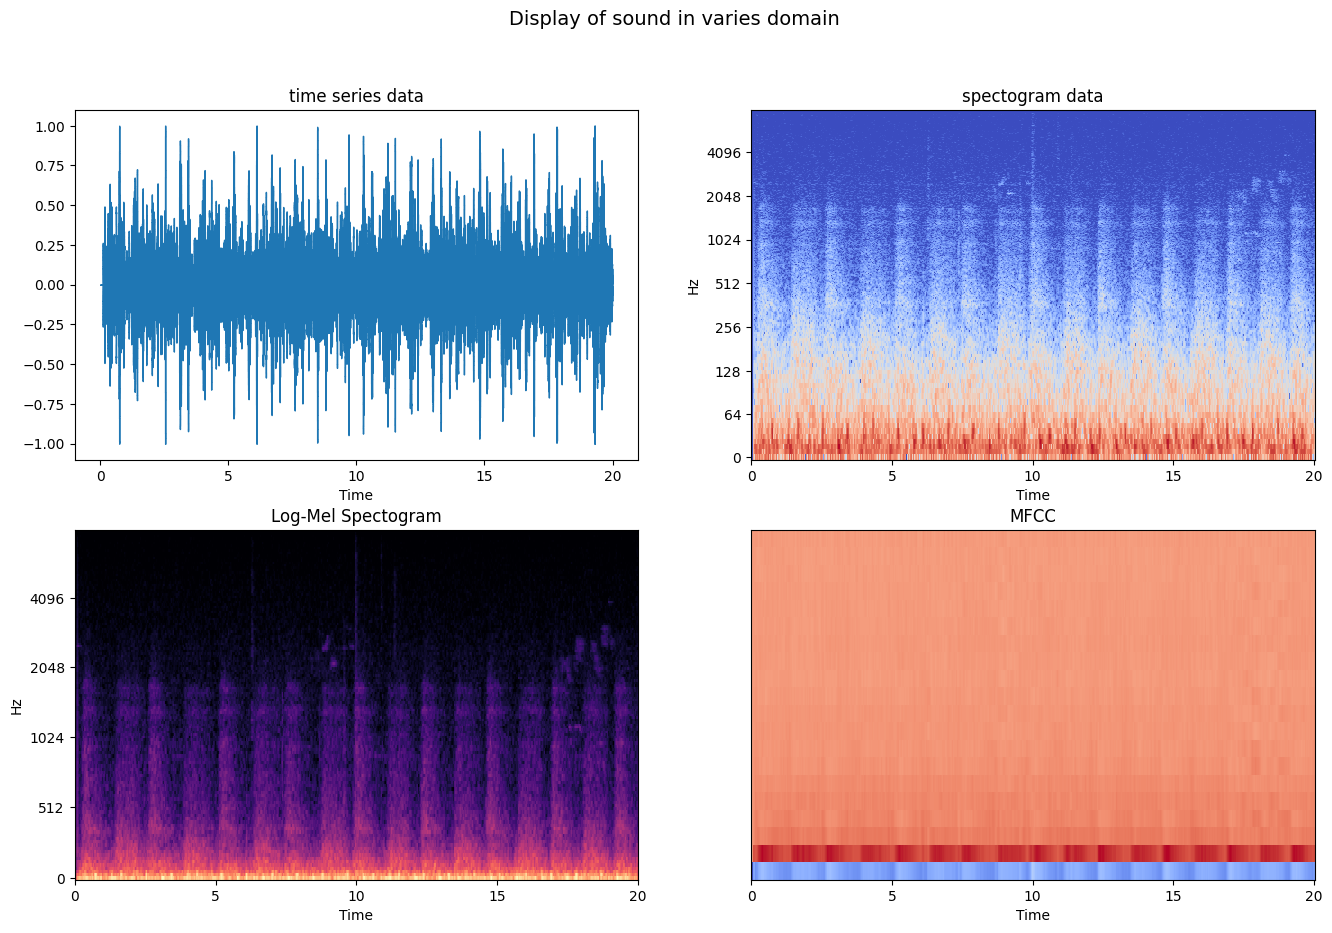

In [ ]:
# Displaying sound data
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);

# **Preprocessing**

In [ ]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)


    return feature

In [ ]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  # Use os.path.join to correctly construct the file path
  audio_file = os.path.join(audio_path, file_label_df['filename'][i] + '.wav')
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)

  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
preprocessed_data[0].shape

(20, 157)

In [ ]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [ ]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8)

#encoder_3 = LabelEncoder()
#i_labels_3 = encoder_3.fit_transform(labels_3)
#oh_labels_3 = to_categorical(i_labels_3)

In [ ]:
oh_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
type(oh_labels)

numpy.ndarray

In [ ]:
print(list(encoder.classes_))

['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


# **Highly Imbalance Dataset**

In [ ]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels,
                                                    test_size=0.2, random_state = 42)

In [ ]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  736
size of testing set=  184


In [ ]:
oh_labels.shape

(920, 8)

# **Training and Testing**

# Without miniority class upsampling

In [ ]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
y_train[1].shape

(8,)

In [ ]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5503 - loss: 6.3570
Epoch 1: val_accuracy improved from -inf to 0.01351, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 753ms/step - accuracy: 0.5649 - loss: 6.1999 - val_accuracy: 0.0135 - val_loss: 3.2611
Epoch 2/300
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6382 - loss: 2.5851 
Epoch 2: val_accuracy improved from 0.01351 to 0.86486, saving model to mymodel2_02.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6896 - loss: 2.3416 - val_accuracy: 0.8649 - val_loss: 1.0312
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8496 - loss: 1.1653 
Epoch 3: val_accuracy did not improve from 0.86486
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8487 - loss: 1.1631 - val_accuracy: 0.8514 - val_loss: 0.7587
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8761 - loss: 0.7358 
Epoch 4: val_accuracy did not improve from 0.86486
11/11 ━━━━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

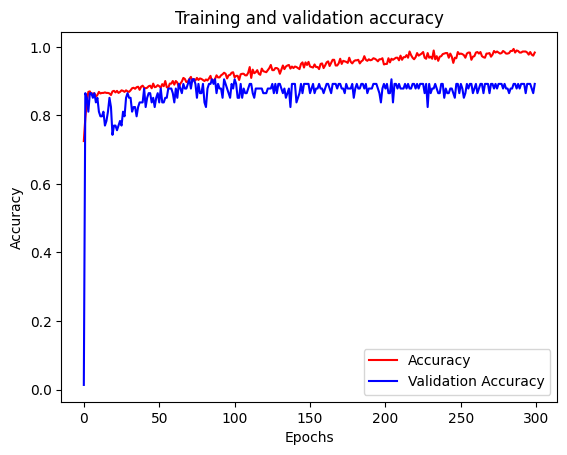

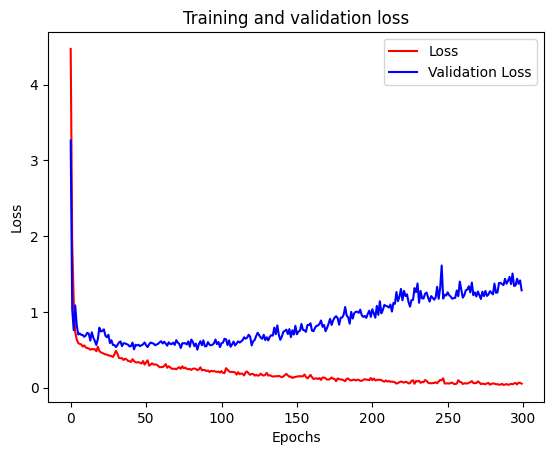

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9864130616188049
Testing Accuracy:  0.8369565010070801


In [ ]:
preds = model.predict(x_test) # label scores

classpreds = np.argmax(preds, axis=1) # predicted classes

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [ ]:
encoder.classes_

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype='<U14')

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI']

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


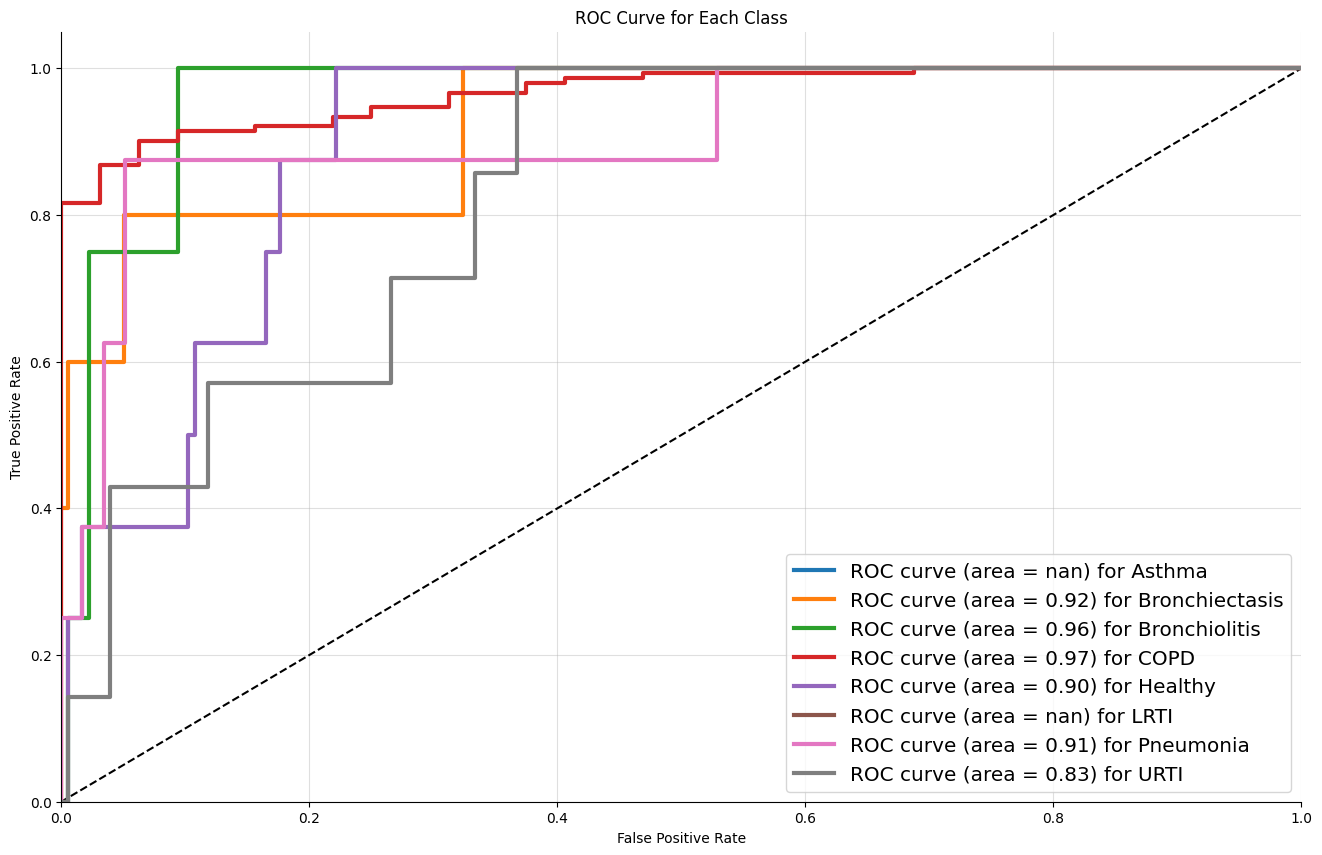

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
c_names

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  2   0   2   1   0   0]
 [  0   3   1   0   0   0]
 [  0   1 142   3   5   1]
 [  0   2   2   3   1   0]
 [  0   0   3   1   4   0]
 [  1   5   0   1   0   0]]


# **second approach (fixing class imbalance)**

In [ ]:
preprocessed_data.shape

(920, 20, 157, 1)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np



n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler()

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)


# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of X_resampled: (6344, 3140)
Shape of y_resampled: (6344, 8)


In [ ]:
X_restored.shape

(6344, 20, 157, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled, stratify=y_resampled,
                                                    test_size=0.2, random_state = 42)

In [ ]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  5075
size of testing set=  1269


In [ ]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1692 - loss: 4.7421
Epoch 1: val_accuracy improved from -inf to 0.37992, saving model to mymodel3_01.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.1702 - loss: 4.7142 - val_accuracy: 0.3799 - val_loss: 1.7228
Epoch 2/300
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4208 - loss: 1.5640
Epoch 2: val_accuracy improved from 0.37992 to 0.61614, saving model to mymodel3_02.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4219 - loss: 1.5621 - val_accuracy: 0.6161 - val_loss: 1.4092
Epoch 3/300
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5550 - loss: 1.3133
Epoch 3: val_accuracy improved from 0.61614 to 0.64173, saving model to mymodel3_03.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5563 - loss: 1.3106 - val_accuracy: 0.6417 - val_loss: 1.1985
Epoch 4/300
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6423 - loss: 1.1215
Epoch 4: val_accuracy improved from 0.64173 

<Figure size 640x480 with 0 Axes>

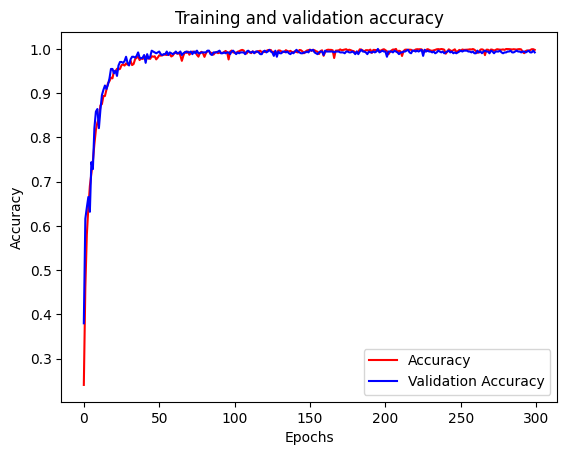

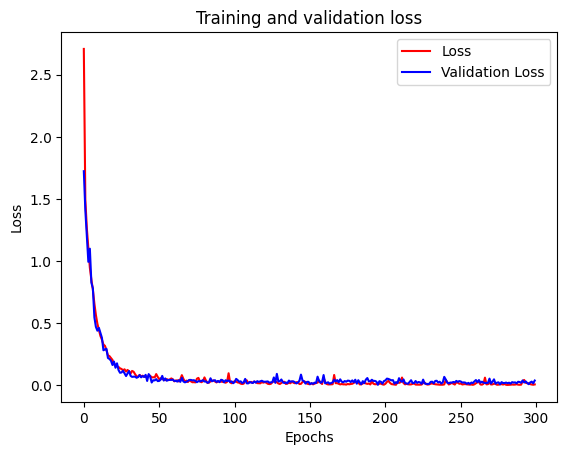

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9986206889152527
Testing Accuracy:  0.9936957955360413


In [ ]:
preds = model.predict(x_test) # label scores

classpreds = np.argmax(preds, axis=1) # predicted classes

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

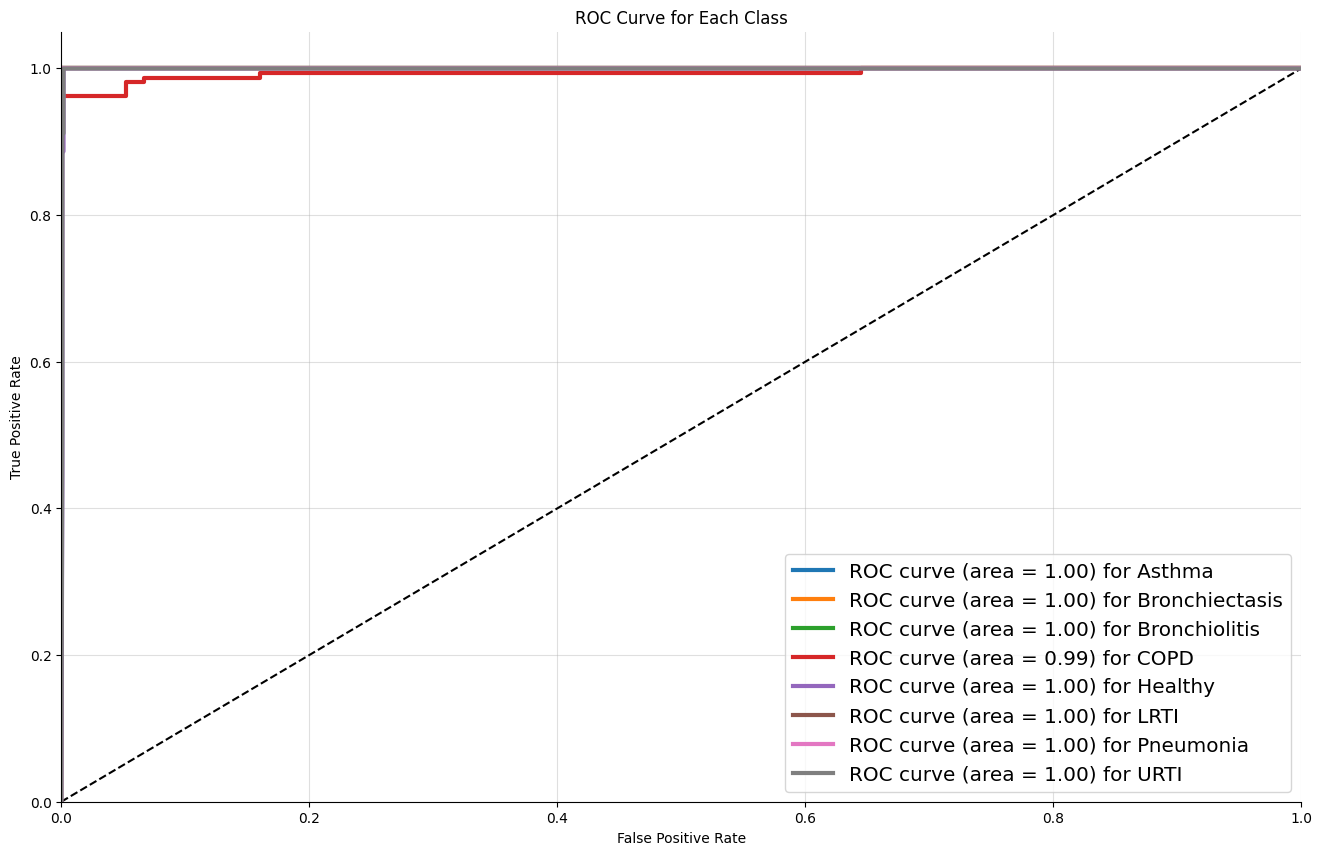

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

        Asthma       0.99      1.00      1.00       159
Bronchiectasis       0.99      1.00      1.00       159
 Bronchiolitis       1.00      1.00      1.00       158
          COPD       1.00      0.95      0.97       159
       Healthy       0.99      1.00      0.99       159
          LRTI       1.00      1.00      1.00       159
     Pneumonia       0.99      1.00      1.00       158
          URTI       0.98      1.00      0.99       158

      accuracy                           0.99      1269
     macro avg       0.99      0.99      0.99      1269
  weighted avg       0.99      0.99      0.99      1269



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   0   0   0   0   0   0   0]
 [  0 159   0   0   0   0   0   0]
 [  0   0 158   0   0   0   0   0]
 [  1   1   0 151   2   0   1   3]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0   0 159   0   0]
 [  0   0   0   0   0   0 158   0]
 [  0   0   0   0   0   0   0 158]]


**Save model as saved model format**

In [ ]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
# saving model in HDF5 format
model.save('prediction_lung_disease_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('prediction_lung_disease_model.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 19, 156, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9, 78, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9, 78, 64)           │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 77, 32)           │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 38, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4, 38, 64)           │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 37, 64)           │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,418 (333.67 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,946 (222.45 KB)

In [ ]:
def predict_audio(file_path, model, encoder):
    # Preprocess ไฟล์เสียง
    data = preprocessing(file_path, mode='mfcc')

    # พยากรณ์ผลลัพธ์
    preds = model.predict(data)[0]

    # พิมพ์ผลลัพธ์ของ preds
    print(f"Predictions: {preds}")

    # ดึงเปอร์เซ็นต์แต่ละคลาส
    probabilities = {label: preds[i] * 100 for i, label in enumerate(encoder.classes_)}

    # ตรวจสอบ index ของคลาสที่คาดการณ์
    predicted_class = encoder.classes_[np.argmax(preds)]

    return {
        'predicted_class': predicted_class,
        'probabilities': probabilities
    }
